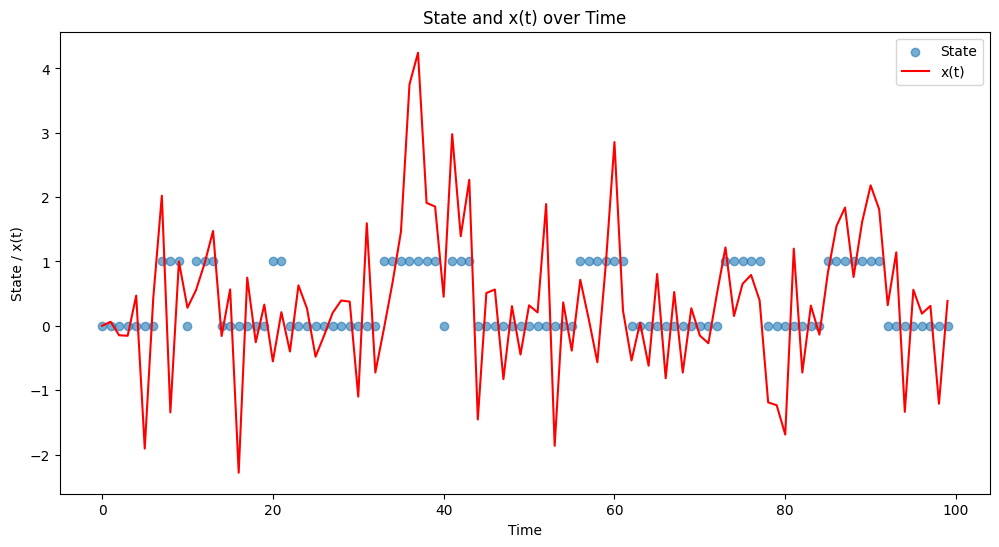

{'phi': [-0.35, 0.6],
 'mu': [-0.1, 0.4],
 'omega': [0.1, 0.4],
 'alpha': [0.1, 0.15],
 'beta': [0.6, 0.75],
 'p11': 0.9,
 'p22': 0.8}

In [84]:
# Revised code to correctly handle the state transitions and use different parameters for each state

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
# Set the random seed for reproducibility
# np.random.seed(0)

num_obs = 100

# Generating two sets of parameters for each state
phi = np.random.uniform(-1, 1, size=2)  # Two values of phi in [-1, 1]
mu = np.random.uniform(-1, 1, size=2)  # Two values of mu in [-1, 1]
omega = np.random.uniform(0.01, 1, size=2)  # Two values of omega in [0.01, 1]
alpha = np.random.uniform(0.01, 1, size=2)  # Two values of alpha in [0.01, 1]
beta = np.array(np.absolute([np.random.uniform(0.01, 1 - 0.5*alpha[i]- 0.5*phi[i]) for i in range(2)]))  # Two values of beta
df = np.random.randint(15, 150, size=2)  # Two values for degrees of freedom
nu = np.random.uniform(0, 5, size=2)  # Two values for variance

# Transition probabilities for the Markov Switching
p11 = np.random.uniform(0, 1)  # Transition probability from state 1 to state 1
p22 = np.random.uniform(0, 1)  # Transition probability from state 2 to state 2

# Custom defining variables for testing
# Generating two sets of parameters for each state
phi = [-0.35,0.6]
mu = [-0.1,0.4]
omega = [0.1,0.4]
alpha = [0.1,0.15]
beta = [0.6,0.75]
df = [16,32]  # Two values for degrees of freedom
nu = [0.8,3.2]  # Two values for variance

# Transition probabilities for the Markov Switching
p11 = 0.9  # Transition probability from state 1 to state 1
p22 = 0.8  # Transition probability from state 2 to state 2
# Initialize the arrays



x = np.zeros(num_obs)
sigma = np.zeros(num_obs)
states = np.zeros(num_obs, dtype=int)
z = np.zeros(num_obs)

# Generate observations and states
for t in range(1, num_obs):
    # Determine the state transition
    if states[t-1] == 0:
        states[t] = 0 if np.random.rand() < p11 else 1
    else:
        states[t] = 1 if np.random.rand() < p22 else 0

    # t-distributed noise with specified df and variance for each state
    # z[t] = np.random.standard_t(df[states[t]]) * np.sqrt(nu[states[t]])
    z[t] = np.random.normal(0,1)
    # Calculate sigma and x using the state-dependent parameters
    sigma[t] = z[t] * (omega[states[t]] + alpha[states[t]] * x[t-1] ** 2 + beta[states[t]] * z[t-1] ** 2) ** 0.5
    x[t] = mu[states[t]] + phi[states[t]] * x[t-1] + sigma[t]

# Store results in a DataFrame
data = pd.DataFrame({
    'Time': range(num_obs),
    'x': x,
    'sigma': sigma,
    'z': z,
    'State': states
})

# Scatterplot with state on the y-axis and time on the x-axis
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'], data['State'], alpha=0.6, label='State')
plt.plot(data['Time'], data['x'], color='red', label='x(t)')
plt.xlabel('Time')
plt.ylabel('State / x(t)')
plt.title('State and x(t) over Time')
plt.legend()
plt.show()

# Print the parameters
true_parameters = {
    'phi': phi,
    'mu': mu,
    'omega': omega,
    'alpha': alpha,
    'beta': beta,
    #'df': df,
    #'nu': nu,
    'p11': p11,
    'p22': p22
}
true_parameters



# Expectation Maximization Algorithm Class

In [89]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

class MS_ME:

    def __init__(self, data, lags, regimes):
        """
        Initialize the MS-AR model parameters.
        :param data: pandas DataFrame, time series data.
        :param lags: int, number of lags in the AR model.
        :param regimes: int, number of regimes in the Markov-switching model.
        """
        self.data = data.values if isinstance(data, pd.DataFrame) else data
        self.lags = lags
        self.regimes = regimes
        self.parameters = self.initialize_params(self.lags, self.regimes)
        #print(len(self.data))

    def initialize_params(self, lags, regimes):
        """
        Initialize model parameters randomly.
        :param lags: int, number of lags in the AR model.
        :param regimes: int, number of regimes.
        :return: dict, initialized parameters.
        """
        alpha = np.random.randn(regimes, lags)  # Alpha parameters for each regime
        phi = np.random.randn(regimes, lags)  # Phi parameters for each regime

        # Transition probability matrix for the regimes
        transition_matrix = np.full((regimes, regimes), 1.0 / regimes)

        return {
            "alpha": alpha,
            "phi": phi,
            "transition_matrix": transition_matrix
        }
    def forward_pass(self, data, params):
        # Print the type and length of data for debugging
        # print("Type of data in forward_pass:", type(data))
        # print("Length of data in forward_pass:", len(data))
        num_data_points = len(data)
        alpha = params['alpha']
        phi = params['phi']
        transition_matrix = params['transition_matrix']

        # Initializing filtered probabilities array
        filtered_probs = np.zeros((num_data_points, self.regimes))

        # Initial state probabilities (can be uniform or based on prior knowledge)
        filtered_probs[0, :] = 1.0 / self.regimes

        for t in range(1, num_data_points):
            for state in range(self.regimes):
                # Calculate the probability of the data point given the state
                # This requires a likelihood function for your AR model
                likelihood = self.calculate_likelihood(data[t], data[t-1], alpha[state], phi[state])

                # Update filtered probability for each state
                filtered_probs[t, state] = likelihood * np.sum(filtered_probs[t-1, :] * transition_matrix[:, state])

            # Normalize probabilities to sum to 1
            filtered_probs[t, :] /= np.sum(filtered_probs[t, :])

        return filtered_probs

    def backward_pass(self, filtered_probs, params):
        num_data_points = len(filtered_probs)
        transition_matrix = params['transition_matrix']

        # Initializing smoothed probabilities array
        smoothed_probs = np.copy(filtered_probs)

        for t in range(num_data_points - 2, -1, -1):
            for state in range(self.regimes):
                # Compute the backward probability
                backward_prob = np.sum(transition_matrix[state, :] * smoothed_probs[t + 1, :])

                # Update smoothed probability
                smoothed_probs[t, state] *= backward_prob

            # Normalize probabilities to sum to 1
            smoothed_probs[t, :] /= np.sum(smoothed_probs[t, :])

        return smoothed_probs

    def calculate_state_probability(self, data, state, params, t):
        """
        Calculate smoothed state probabilities at time t using forward-backward algorithm.
        :param data: pandas DataFrame, time series data.
        :param params: dict, current model parameters.
        :param t: int, time step.
        :return: numpy array, smoothed state probabilities at time t.
        """
        filtered_probs = self.forward_pass(data, params)
        smoothed_probs = self.backward_pass(filtered_probs, params)
        return smoothed_probs[t,state]# :]

    def calculate_likelihood(self, data, params):
        """
        Calculate the log likelihood of the data given the model parameters.
        :param data: numpy array, time series data.
        :param params: dict, current model parameters.
        :return: float, log likelihood of the data.
        """
        num_data_points = len(data)
        log_likelihood = 0


        # Compute smoothed state probabilities
        filtered_probs = self.forward_pass(data, params)
        smoothed_probs = self.backward_pass(filtered_probs, params)
        
        for t in range(1, num_data_points):
            # Determine the most likely state at time t
            state = np.argmax(smoothed_probs[t, :])
            
            mu = params['mu'][state]
            phi = params['phi'][state]
            omega = params['omega'][state]
            alpha = params['alpha'][state]
            beta = params['beta'][state]
    
            # Calculate sigma[t] based on the model
            if t == 1:
                sigma_t_squared = omega + alpha * data[t-1]**2
            else:
                sigma_t_squared = omega + alpha * data[t-1]**2 + beta * (sigma[t-1]**2)
            sigma_t = np.sqrt(sigma_t_squared)
    
            # Log likelihood calculation
            term1 = -0.5 * np.log(2 * np.pi)
            term2 = -0.5 * np.log(sigma_t_squared)
            term3 = -((data[t] - mu - phi * data[t-1])**2) / (2 * sigma_t_squared)
    
            log_likelihood += term1 + term2 + term3
        
        return log_likelihood


    def e_step(self, data, params):
        """
        E-step - estimate expected values of latent variables.
        :param data: pandas DataFrame, time series data.
        :param params: dict, current model parameters.
        :return: numpy array, expected latent states.
        """
        num_data_points = len(data)
        expected_states = np.zeros((num_data_points, self.regimes))

        # Example: Calculating the expected state probabilities
        for t in range(1, num_data_points):
            for state in range(self.regimes):
                # Probability of being in 'state' at time t given data and parameters
                # Placeholder for actual logic:
                # You need to implement how to calculate these probabilities
                # based on the current parameters and the observed data.
                prob_state_given_data = self.calculate_state_probability(data, state, params, t)
                expected_states[t, state] = prob_state_given_data

        self.smoothed_probabilities = expected_states
        return expected_states

   

    def m_step(self, data, expected_states):
        """
        M-step - maximize the expected log-likelihood with respect to the parameters.
        :param data: pandas DataFrame or numpy array, time series data.
        :param expected_states: numpy array, expected state probabilities from E-step.
        """
        num_data_points = len(data)
        # new_params = {}
        new_alpha = np.zeros((self.regimes, self.lags))
        new_phi = np.zeros((self.regimes, self.lags))
        # Updating parameters for each state
        for state in range(self.regimes):
            # Defining the objective function to be minimized (negative log-likelihood)
            def objective(params):
                alpha, phi = params
                log_likelihood = 0
                for t in range(1, num_data_points):
                    likelihood = self.calculate_likelihood(data[t], data[t-1], alpha, phi)
                    # Weighted log-likelihood for this state
                    log_likelihood += expected_states[t, state] * np.log(likelihood)
                return -log_likelihood

            # Initial guesses for alpha and phi
            # print(self.parameters['alpha'][state,0], self.parameters['phi'][state,0])
            initial_guess = np.array([self.parameters['alpha'][state,0], self.parameters['phi'][state,0]])

            # Numerical optimization
            result = minimize(objective, initial_guess, method='L-BFGS-B')
            new_alpha[state, 0], new_phi[state, 0] = result.x

            # Update parameters for this state
            #new_params[state] = {'alpha': new_alpha, 'phi': new_phi}
            # Update transition probabilities
        num_transitions = np.zeros((self.regimes, self.regimes))

        for t in range(1, num_data_points):
            for i in range(self.regimes):
                for j in range(self.regimes):
                    num_transitions[i, j] += expected_states[t-1, i] * expected_states[t, j]

        # Normalizing to get probabilities
        new_transition_matrix = num_transitions / num_transitions.sum(axis=1, keepdims=True)

        # Update parameters
        self.parameters = {
            'alpha': new_alpha,
            'phi': new_phi,
            'transition_matrix': new_transition_matrix  # Use the new transition matrix
        }


    def fit(self, max_iterations=100, tolerance=1e-6):
        """
        Fit the MS-AR model using the EM algorithm.
        :param max_iterations: int, maximum number of iterations for the EM algorithm.
        :param tolerance: float, convergence tolerance for the EM algorithm.
        """
        self.alpha_history = []
        self.phi_history = []

        log_likelihood_old = -np.inf

        for iteration in range(max_iterations):
            # E-step: Estimate expected state probabilities
            expected_states = self.e_step(self.data, self.parameters)

            # M-step: Update model parameters
            self.m_step(self.data, expected_states)


            self.alpha_history.append(self.parameters['alpha'].copy())
            self.phi_history.append(self.parameters['phi'].copy())

            # Calculating the new log-likelihood
            log_likelihood_new = self.calculate_total_log_likelihood(self.data, self.parameters, expected_states)

            # Check for convergence
            if np.abs(log_likelihood_new - log_likelihood_old) < tolerance:
                print(f"EM algorithm converged at iteration {iteration}")
                break

            log_likelihood_old = log_likelihood_new
            print(f"Current step: {iteration} out of {max_iterations}... With Estimated Parameters Currently at {self.parameters}" )
        else:
            print("EM algorithm did not converge")

    def calculate_total_log_likelihood(self, data, params, expected_states):
        """
        Calculate the total log-likelihood of the data given the model parameters and expected states.
        :param data: pandas DataFrame or numpy array, time series data.
        :param params: dict, current model parameters.
        :param expected_states: numpy array, expected state probabilities from E-step.
        :return: float, total log-likelihood.
        """
        total_log_likelihood = 0
        num_data_points = len(data)

        for t in range(1, num_data_points):
            for state in range(self.regimes):
                # print(params['alpha'])
                # print(params['phi'])
                alpha = params['alpha'][state, 0]  # Access alpha for the current state
                phi = params['phi'][state, 0]      # Access phi for the current state
                likelihood = self.calculate_likelihood(data[t], data[t-1], alpha, phi)
                total_log_likelihood += expected_states[t, state] * np.log(likelihood)
                
                
        return total_log_likelihood


    def predict(self):
        if self.parameters is None:
            print("Model is not yet fitted.")
            return None

        num_data_points = len(self.data)
        predictions = np.zeros(num_data_points)
        
        # Initialize the first state (this could be based on initial probabilities or set to a default)
        current_state = 0  # or some initialization logic

        for t in range(1, num_data_points):
            # Get the parameters for the current state
            alpha = self.parameters['alpha'][current_state, 0]
            phi = self.parameters['phi'][current_state, 0]
            
            # Predict the next value
            predictions[t] = alpha + phi * self.data[t-1]
            
            # Update the state (this is a simplification; in practice, you'd use the transition probabilities)
            # Example: current_state = np.random.choice(self.regimes, p=transition_probabilities[current_state])
            # For simplicity, we keep the state constant in this example.

        return predictions

    def plot_results(self):
        """
        Plot Results of the estimation.
        - Plot the convergence of parameters
        - Plot residuals, and distribution
        - Plot the Smoothed probabilities. 
        """
        # Plotting alpha values
        plt.figure(figsize=(12, 6))
        for state in range(self.regimes):
            alphas = [alpha_history[state, 0] for alpha_history in self.alpha_history]
            plt.plot(alphas, label=f'Alpha State {state}')
        plt.xlabel('Iteration')
        plt.ylabel('Alpha Value')
        plt.title('Alpha Values over Iterations')
        plt.legend()
        plt.show()

        # Plotting phi values
        plt.figure(figsize=(12, 6))
        for state in range(self.regimes):
            phis = [phi_history[state, 0] for phi_history in self.phi_history]
            plt.plot(phis, label=f'Phi State {state}')
        plt.xlabel('Iteration')
        plt.ylabel('Phi Value')
        plt.title('Phi Values over Iterations')
        plt.legend()
        plt.show()

    def plot_convergence(self, true_phi=None, true_alpha=None):
        # Plotting alpha values
        plt.figure(figsize=(12, 3))
        for state in range(self.regimes):
            alphas = [alpha_history[state, 0] for alpha_history in self.alpha_history]
            plt.plot(alphas, label=f'Alpha State {state}')
            if true_alpha is not None:
                plt.axhline(y=true_alpha[state], color='r', linestyle='--', label=f'True Alpha State {state}')
        plt.xlabel('Iteration')
        plt.ylabel('Alpha Value')
        plt.title('Alpha Values over Iterations')
        plt.legend()
        plt.show()

        # Plotting phi values
        plt.figure(figsize=(12, 3))
        for state in range(self.regimes):
            phis = [phi_history[state, 0] for phi_history in self.phi_history]
            plt.plot(phis, label=f'Phi State {state}')
            if true_phi is not None:
                plt.axhline(y=true_phi[state], color='g', linestyle='--', label=f'True Phi State {state}')
        plt.xlabel('Iteration')
        plt.ylabel('Phi Value')
        plt.title('Phi Values over Iterations')
        plt.legend()
        plt.show()

    def plot_smoothed_probabilities(self, true_states=None):
        if not hasattr(self, 'smoothed_probabilities'):
            print("No smoothed probabilities available. Run fit method first.")
            return

        num_states = self.regimes
        fig, axes = plt.subplots(num_states, 1, figsize=(12, 3 * num_states))

        for state in range(num_states):
            ax = axes[state] if num_states > 1 else axes
            # Plot the smoothed probabilities for each state
            ax.plot(self.smoothed_probabilities[:, state], label=f'State {state} Probability')
            ax.set_title(f'Smoothed Probability of being in State {state}')
            ax.set_xlabel('Observation')
            ax.set_ylabel('Probability')

            if true_states is not None:
                # Overlay the true states if provided
                true_state_indicator = (true_states == state).astype(int)
                ax.scatter(range(len(true_states)), true_state_indicator, label=f'True State {state}', alpha=0.5, marker='o')

            ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_model_diagnostics(self):
        if not hasattr(self, 'data') or self.parameters is None:
            print("Model or data is not available.")
            return

        estimated_values = self.predict()  # Assuming 'predict' method exists and returns estimated values
        residuals = self.data - estimated_values

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Colors
        observed_color = 'skyblue'
        estimated_color = 'salmon'
        residual_color = 'lightgreen'
        histogram_color = 'plum'
        normal_dist_color = 'darkred'

        # Plot 1: Estimation vs. Data
        axes[0, 0].plot(self.data, label='Observed Data', color=observed_color)
        axes[0, 0].plot(estimated_values, label='Estimated Data', color=estimated_color, linestyle='--')
        axes[0, 0].set_title('Observed vs. Estimated Data')
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].legend()

        # Plot 2: Residuals
        axes[0, 1].plot(residuals, label='Residuals', color=residual_color)
        axes[0, 1].set_title('Residuals over Time')
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Residual')
        axes[0, 1].legend()

        # Plot 3: Histogram of Residuals
        sns.histplot(residuals, kde=False, ax=axes[1, 0], color='blue', label='Residuals')
        xmin, xmax = axes[1, 0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = np.exp(-x**2/2) / np.sqrt(2 * np.pi)
        scale_factor = len(residuals) * (xmax - xmin) / (np.max(np.histogram(residuals, bins=100)[0]))
        axes[1, 0].plot(x, p * scale_factor, label='Normal Distribution', color=normal_dist_color)
        axes[1, 0].set_title('Histogram of Residuals')
        axes[1, 0].legend()
        
        # Plot 4: Autocorrelation of Residuals
        plot_acf(residuals, ax=axes[1, 1], alpha=0.05, color='steelblue')
        axes[1, 1].set_title('Autocorrelation of Residuals')

        plt.tight_layout()
        plt.show()



    def summary(self):
        """
        Create a summary of the model estimation results.
        """
        if self.parameters is None:
            print("Model is not yet fitted.")
            return

        # Displaying Model Parameters
        print("Model Parameters:")
        for state in range(self.regimes):
            print(f"State {state}:")
            print(f"  Alpha: {self.parameters['alpha'][state,0]}")
            print(f"  Phi: {self.parameters['phi'][state,0]}")
        print("\n")

        # Final Log-Likelihood
        expected_states = self.e_step(self.data, self.parameters)
        final_log_likelihood = self.calculate_total_log_likelihood(self.data, self.parameters, expected_states)
        print(f"Final Log-Likelihood: {final_log_likelihood}")
        print("\n")

        # Test Statistics (e.g., AIC, BIC)
        num_params = self.regimes * 2  # Number of parameters (alpha and phi for each state)
        aic = -2 * final_log_likelihood + 2 * num_params
        bic = -2 * final_log_likelihood + np.log(len(self.data)) * num_params
        print("Test Statistics:")
        print(f"  AIC: {aic}")
        print(f"  BIC: {bic}")
        print("\n")

        # State Probabilities
        print("Estimated State Probabilities:")
        for t, probs in enumerate(expected_states):
            print(f"Time {t}: {probs}")

SyntaxError: invalid syntax (2294707410.py, line 114)

model = MS_VAR.MS_ME(data['Observation'].values, lags, regimes)
model.fit(max_iterations=500, tolerance=1e-6)